### Distribution Shift Detection Again

Objective: Detect distribution shift between X_train and Test2[:202].

Methods:

1. Employ a Random Forest Domain Classifier to assess the discriminability between the two domains. The Area Under the Curve (AUC) of the classifier's performance is utilized to quantify its ability to distinguish between the two domains; a higher AUC indicates a greater degree of separability.

2. Conduct the Kolmogorov-Smirnov (KS) Test on each individual feature. The p-value obtained from the KS test is used to evaluate the statistical significance of the distributional differences for each feature. A small p-value (e.g., below a pre-defined significance level, typically 0.05) suggests that the distributions of the feature in the two datasets are significantly different.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

X_train = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y_train = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()
X_test2 = pd.read_csv("../data/X_test_2.csv", skiprows=1, header=None).values
y_test2 = pd.read_csv("../data/y_test_2_reduced.csv", skiprows=1, header=None).values.ravel()

# train set combine with Test2[:202]
X_domain = np.vstack([X_train, X_test2[:202]])
y_domain = np.hstack([np.zeros(X_train.shape[0]), np.ones(202)])  # 0: train, 1: test2[:202]

# Domain Classifier(RF)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, val_idx in kf.split(X_domain, y_domain):
    X_tr, X_val = X_domain[train_idx], X_domain[val_idx]
    y_tr, y_val = y_domain[train_idx], y_domain[val_idx]

    clf_rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
    clf_rf.fit(X_tr, y_tr)
    y_val_prob = clf_rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_prob)
    auc_scores.append(auc)

print(f"[RF Domain Classifier] ROC AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# RF feature importance selection
clf_rf_full = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
clf_rf_full.fit(X_domain, y_domain)
feature_importances = clf_rf_full.feature_importances_
important_feats_rf = pd.DataFrame({'feature': np.arange(X_train.shape[1]), 'importance': feature_importances})
important_feats_rf = important_feats_rf.sort_values(by='importance', ascending=False).reset_index(drop=True)
print("\nTop 10 Important Features (RF Domain Classifier):")
print(important_feats_rf.head(10))

# Covariate Shift(KS test)
ks_results = []
for i in range(X_train.shape[1]):
    stat, p_value = ks_2samp(X_train[:, i], X_test2[:202, i])
    ks_results.append((i, p_value))
ks_df = pd.DataFrame(ks_results, columns=['feature', 'p_value']).sort_values(by='p_value')

print("\nTop 10 Features with Smallest KS p-values:")
print(ks_df.head(10))

# Static distribution shift
shifted_feats = ks_df[ks_df['p_value'] < 1e-3]['feature'].tolist()
print(f"\nDetected {len(shifted_feats)} shifted features (p < 0.001)")


[RF Domain Classifier] ROC AUC: 0.7032 ± 0.0366

Top 10 Important Features (RF Domain Classifier):
   feature  importance
0      204    0.010686
1      214    0.010547
2       71    0.009638
3      249    0.009564
4      242    0.008339
5      208    0.008236
6      163    0.008108
7      141    0.008107
8       33    0.007888
9      267    0.007849

Top 10 Features with Smallest KS p-values:
     feature       p_value
249      249  6.404787e-22
90        90  3.835617e-21
141      141  1.165150e-17
46        46  1.161600e-16
270      270  1.510417e-15
172      172  3.671094e-14
182      182  2.414228e-13
71        71  2.760243e-13
86        86  2.959730e-13
125      125  2.575291e-12

Detected 109 shifted features (p < 0.001)


**Objective**: Remove features with distribution shift to reduce the model's dependence on features that exhibit such shifts.

**Methods**:
1. Remove features for which the p-value obtained from the Kolmogorov-Smirnov (KS) test is less than 0.001.
2. After the cleaning process, the resulting feature sets are used as follows:
    - `X_train_cleaned_rf` for the training data after feature cleaning for the Random Forest model.
    - `X_test2_labeled_cleaned_rf` (the first 202 rows are labeled) for the labeled part of the second test data after feature cleaning, which can be used for tasks such as evaluating the model's performance on labeled data.
    - `X_test2_unlabeled_cleaned_rf` (the last 1818 rows are unlabeled) for the unlabeled part of the second test data after feature cleaning, which can be applied in scenarios like semi-supervised learning or making predictions on data without known labels. 

In [ ]:
# Filter out shifted features from train and test sets
X_train_cleaned_rf = np.delete(X_train, shifted_feats, axis=1)
X_test2_labeled_cleaned_rf = np.delete(X_test2[:202], shifted_feats, axis=1)
X_test2_unlabeled_cleaned_rf = np.delete(X_test2[202:], shifted_feats, axis=1)

print(f"X_train_cleaned_rf shape: {X_train_cleaned_rf.shape}")
print(f"X_test2_labeled_cleaned_rf shape: {X_test2_labeled_cleaned_rf.shape}")
print(f"X_test2_unlabeled_cleaned_rf shape: {X_test2_unlabeled_cleaned_rf.shape}")


X_train_cleaned_rf shape: (10000, 191)
X_test2_labeled_cleaned_rf shape: (202, 191)
X_test2_unlabeled_cleaned_rf shape: (1818, 191)


**Objective**: Adopt Route A. Train a model on the training set `X_train_cleaned_rf` and directly validate it on `Test2[:202]`.

**Methods**:
1. **Model Training**:
    - Train a Random Forest model with the following hyperparameters:
        - Set the number of estimators (`n_estimators`) to 300.
        - Set the maximum depth (`max_depth`) to 12.
        - Apply class re - weighting to handle class imbalance issues.
2. **Prediction and Evaluation on `Test2[:202]`**:
    - **Macro F1 Score**: Calculate the Macro F1 score to measure the model's performance across all classes, giving equal weight to each class.
    - **Weighted Cross - Entropy (WCE) Loss**: Compute the WCE Loss, which takes into account the class distribution and assigns appropriate weights to different classes during the loss calculation.
    - **Classification Report**: Generate a detailed classification report that includes precision, recall, F1 - score, and support for each class.
    - **Confusion Matrix**: Create a confusion matrix to visualize the model's performance in terms of true positives, false positives, true negatives, and false negatives for each class. 

[Route A RF] Macro F1: 0.31516416045827805
[Route A RF] WCE Loss: 2.3368132412169684

Classification report:
              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000         1
           3     0.0000    0.0000    0.0000         1
           4     0.3333    0.7500    0.4615         4
           5     0.1220    0.5556    0.2000         9
           6     0.5000    1.0000    0.6667         3
           7     0.8333    0.3571    0.5000        14
           8     0.6774    0.7241    0.7000        29
           9     0.0000    0.0000    0.0000         3
          10     0.0870    1.0000    0.1600         2
          11     0.7778    0.7778    0.7778         9
          12     0.7059    0.2791    0.4000        43
          13     0.0000    0.0000    0.0000         1
          14     0.2000    0.1667    0.1818         6
          15     0.0000    0.0000    0.0000         1
          17     0.8571    0.6000    0.7059        10
          18     0.0000   

/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

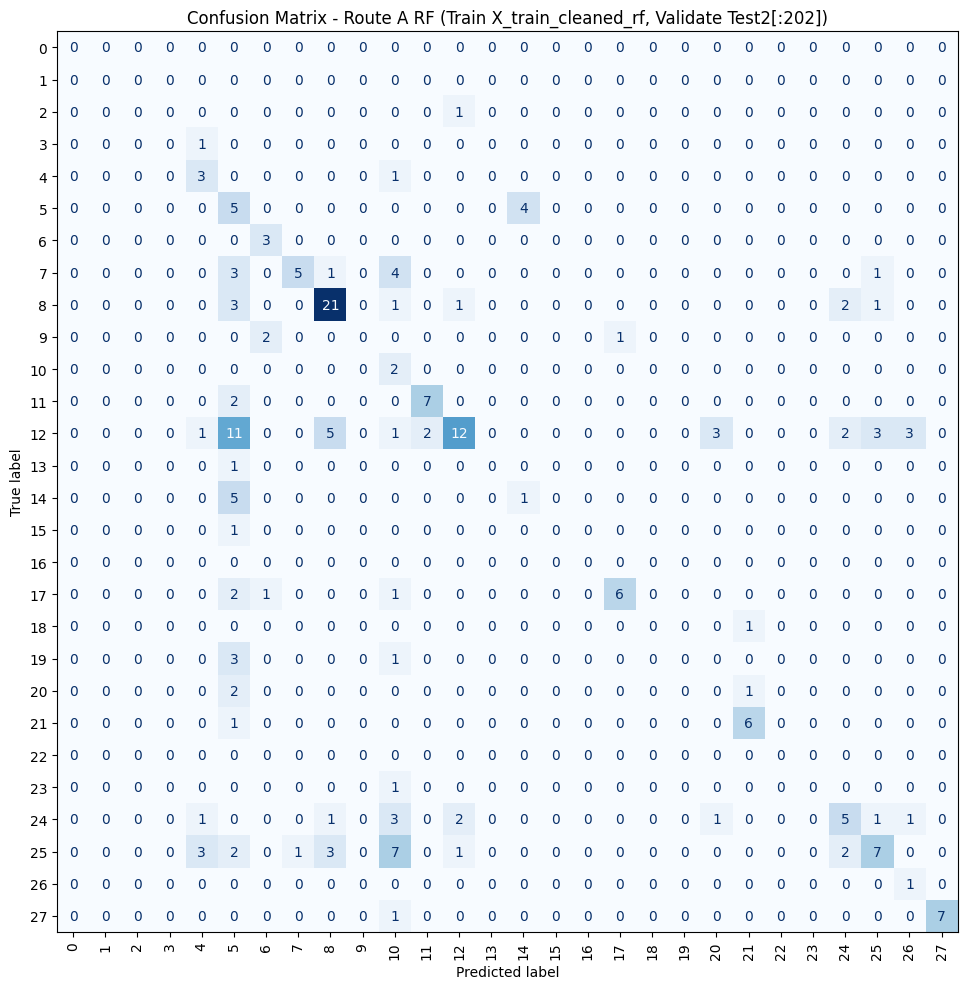

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Route A
clf_rf_a = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1, class_weight='balanced')
clf_rf_a.fit(X_train_cleaned_rf, y_train)

# Valid set
y_val_prob_a = clf_rf_a.predict_proba(X_test2_labeled_cleaned_rf)
y_val_pred_a = clf_rf_a.predict(X_test2_labeled_cleaned_rf)
y_val_onehot = label_binarize(y_test2, classes=np.arange(28))

# Evaluate
print("[Route A RF] Macro F1:", f1_score(y_test2, y_val_pred_a, average='macro'))
print("[Route A RF] WCE Loss:", log_loss(y_val_onehot, y_val_prob_a))
print("\nClassification report:")
print(classification_report(y_test2, y_val_pred_a, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test2, y_val_pred_a, labels=np.arange(28))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(28))
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Route A RF (Train X_train_cleaned_rf, Validate Test2[:202])")
plt.tight_layout()
plt.show()


**Objective**: Adopt Route B. Expand the training set by combining `X_train_cleaned_rf` and `Test2[:202]`, and conduct an 80/20 validation split within the training set.

**Methods**:
1. On the basis of the original training set, attempt to incorporate pseudo - labeled samples from `test2[202:]` with high confidence (confidence level ≥ 0.95).
2. Split the training set into a training subset and a validation subset (80/20 split, using stratified sampling).
3. Train a Random Forest model with the following settings:
    - Set `n_estimators` to 300.
    - Set `max_depth` to 12.
    - Apply class re - weighting.
4. Evaluation:
    - Calculate the Macro F1 score.
    - Compute the Weighted Cross - Entropy (WCE) Loss.
    - Generate a classification report.
    - Create a confusion matrix. 

[Route B RF] Selected 0 pseudo-labeled samples (confidence >= 0.95)
[Route B RF] Macro F1: 0.3302345266104835
[Route B RF] WCE Loss: 2.1558041979459133

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         4
           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         2
           3     0.4000    0.1538    0.2222        13
           4     0.4419    0.3878    0.4130        49
           5     0.7655    0.7416    0.7534       898
           6     0.8226    0.9189    0.8681       111
           7     0.3429    0.5000    0.4068        24
           8     0.6350    0.7982    0.7073       109
           9     0.0000    0.0000    0.0000         6
          10     0.5918    0.7281    0.6529       217
          11     0.6000    0.3529    0.4444        17
          12     0.4815    0.2600    0.3377       100
          13     0.0000    0.0000    0.0000        13
          14 

/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

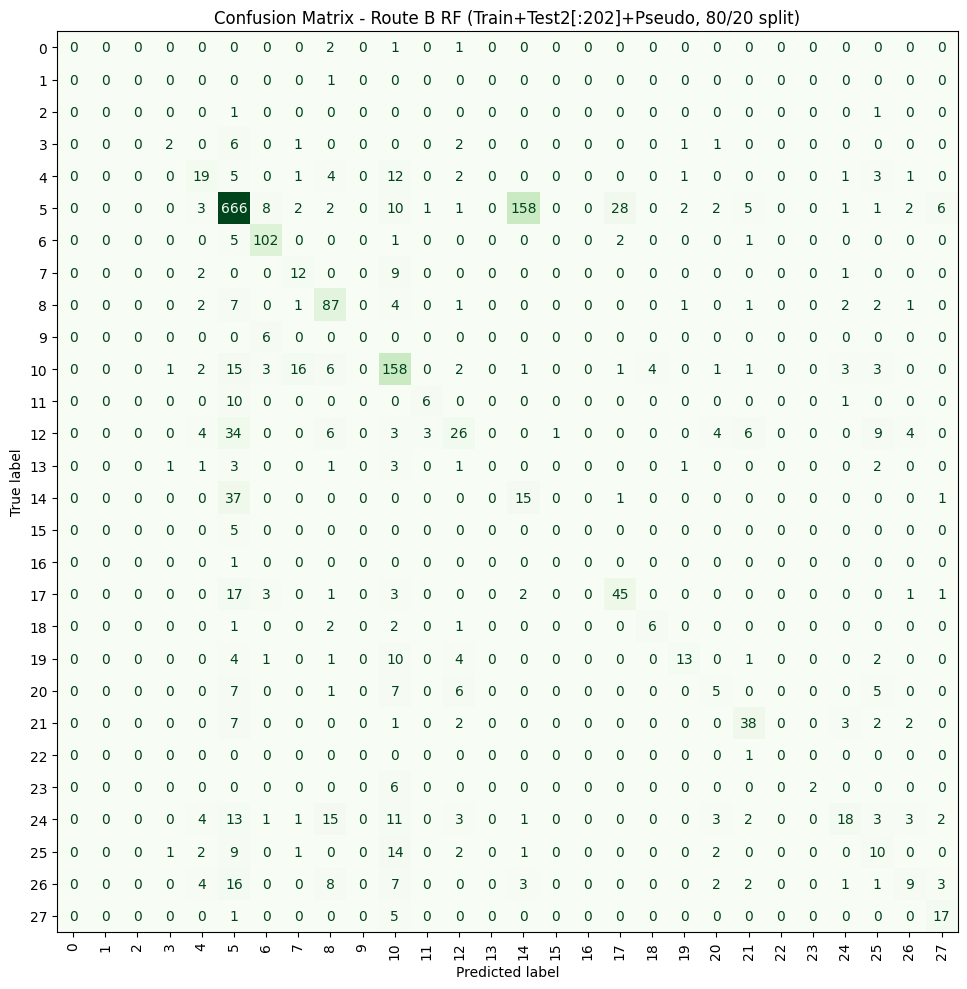

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Combine X_train_cleaned_rf + Test2[:202] as Train set
X_train_combined_rf = np.vstack([X_train_cleaned_rf, X_test2_labeled_cleaned_rf])
y_train_combined_rf = np.hstack([y_train, y_test2])

# Train a Random Forest (RF) model to generate pseudo - label probabilities for test2[202:]
clf_rf_pseudo = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1, class_weight='balanced')
clf_rf_pseudo.fit(X_train_combined_rf, y_train_combined_rf)

y_test2_prob_rf = clf_rf_pseudo.predict_proba(X_test2_unlabeled_cleaned_rf)

# Filter Pseudo - Labeled Samples (with High Confidence)
confidence_threshold = 0.95
max_probs = y_test2_prob_rf.max(axis=1)
pseudo_labels = y_test2_prob_rf.argmax(axis=1)

high_conf_idx = np.where(max_probs >= confidence_threshold)[0]
X_pseudo_rf = X_test2_unlabeled_cleaned_rf[high_conf_idx]
y_pseudo_rf = pseudo_labels[high_conf_idx]

print(f"[Route B RF] Selected {len(high_conf_idx)} pseudo-labeled samples (confidence >= {confidence_threshold})")

# Extend train set
X_train_full_rf = np.vstack([X_train_combined_rf, X_pseudo_rf])
y_train_full_rf = np.hstack([y_train_combined_rf, y_pseudo_rf])

# Split train valid 80/20
X_train_split_rf, X_val_split_rf, y_train_split_rf, y_val_split_rf = train_test_split(
    X_train_full_rf, y_train_full_rf, test_size=0.2, stratify=y_train_full_rf, random_state=42
)

# Train the Final Random Forest (RF) Model (with Class Re - weighting)
clf_rf_b = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1, class_weight='balanced')
clf_rf_b.fit(X_train_split_rf, y_train_split_rf)

# Evaluate on validation set
y_val_prob_b = clf_rf_b.predict_proba(X_val_split_rf)
y_val_pred_b = clf_rf_b.predict(X_val_split_rf)
y_val_onehot_b = label_binarize(y_val_split_rf, classes=np.arange(28))

print("[Route B RF] Macro F1:", f1_score(y_val_split_rf, y_val_pred_b, average='macro'))
print("[Route B RF] WCE Loss:", log_loss(y_val_onehot_b, y_val_prob_b))

print("\nClassification report:")
print(classification_report(y_val_split_rf, y_val_pred_b, digits=4))

# Confusion Matrix
cm_b = confusion_matrix(y_val_split_rf, y_val_pred_b, labels=np.arange(28))
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=np.arange(28))
fig, ax = plt.subplots(figsize=(12, 10))
disp_b.plot(ax=ax, xticks_rotation='vertical', cmap='Greens', colorbar=False)
plt.title("Confusion Matrix - Route B RF (Train+Test2[:202]+Pseudo, 80/20 split)")
plt.tight_layout()
plt.show()


**Objective**: Enhance the model complexity of Route B and attempt to improve its performance.

**Methods**:
1. Increase the parameters of the Random Forest model, setting `n_estimators` to 500 and `max_depth` to 16.
2. Repeat the process of Route B, including training the model and performing an 80/20 validation split. 

[Route B RF - Tweaked] Selected 0 pseudo-labeled samples (confidence >= 0.9)
[Route B RF - Tweaked] Macro F1: 0.2940100418034103
[Route B RF - Tweaked] WCE Loss: 1.7757638177377801

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         4
           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         2
           3     0.0000    0.0000    0.0000        13
           4     0.7143    0.4082    0.5195        49
           5     0.6761    0.9321    0.7837       898
           6     0.8889    0.8649    0.8767       111
           7     0.6250    0.2083    0.3125        24
           8     0.7333    0.7064    0.7196       109
           9     0.0000    0.0000    0.0000         6
          10     0.5762    0.8018    0.6705       217
          11     0.8000    0.2353    0.3636        17
          12     0.5526    0.2100    0.3043       100
          13     0.0000    0.0000    0

/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

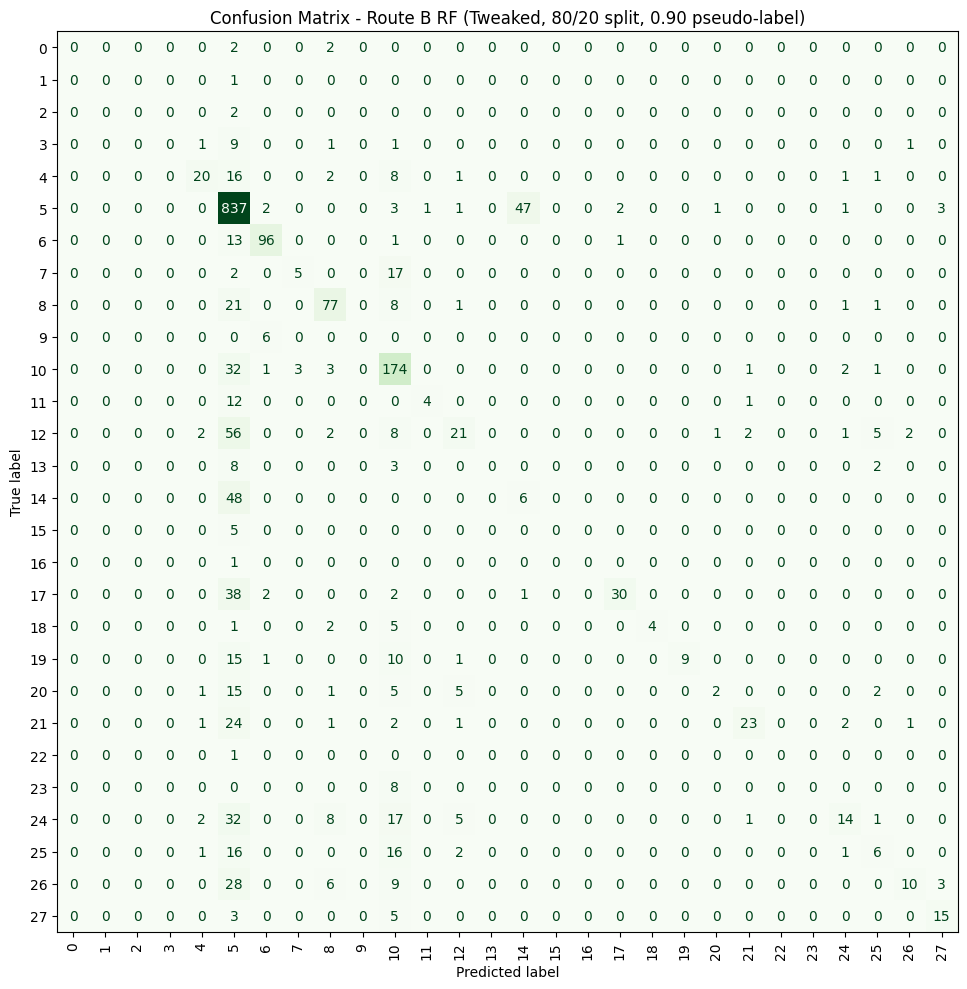

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Combine X_train_cleaned_rf + Test2[:202] as Training Set 
X_train_combined_rf = np.vstack([X_train_cleaned_rf, X_test2_labeled_cleaned_rf])
y_train_combined_rf = np.hstack([y_train, y_test2])

# Train a Random Forest (RF) Model to Generate Pseudo-Label Probabilities for Test2[202:]
clf_rf_pseudo = RandomForestClassifier(n_estimators=500, max_depth=16, random_state=42, n_jobs=-1, class_weight='balanced')
clf_rf_pseudo.fit(X_train_combined_rf, y_train_combined_rf)

y_test2_prob_rf = clf_rf_pseudo.predict_proba(X_test2_unlabeled_cleaned_rf)

# Filter Pseudo-Labeled Samples (High Confidence >= 0.90)
confidence_threshold = 0.90
max_probs = y_test2_prob_rf.max(axis=1)
pseudo_labels = y_test2_prob_rf.argmax(axis=1)

high_conf_idx = np.where(max_probs >= confidence_threshold)[0]
X_pseudo_rf = X_test2_unlabeled_cleaned_rf[high_conf_idx]
y_pseudo_rf = pseudo_labels[high_conf_idx]

print(f"[Route B RF - Tweaked] Selected {len(high_conf_idx)} pseudo-labeled samples (confidence >= {confidence_threshold})")

# Extend Training Set (Original + Pseudo-Labeled Samples)
X_train_full_rf = np.vstack([X_train_combined_rf, X_pseudo_rf])
y_train_full_rf = np.hstack([y_train_combined_rf, y_pseudo_rf])

# Split Training Set into Training and Validation (80/20 Stratified Split)
X_train_split_rf, X_val_split_rf, y_train_split_rf, y_val_split_rf = train_test_split(
    X_train_full_rf, y_train_full_rf, test_size=0.2, stratify=y_train_full_rf, random_state=42
)

# Train Final Random Forest (RF) Model (with Class Re-weighting)
clf_rf_b = RandomForestClassifier(n_estimators=500, max_depth=16, random_state=42, n_jobs=-1, class_weight='balanced')
clf_rf_b.fit(X_train_split_rf, y_train_split_rf)

# Evaluate on Validation Set
y_val_prob_b = clf_rf_b.predict_proba(X_val_split_rf)
y_val_pred_b = clf_rf_b.predict(X_val_split_rf)
y_val_onehot_b = label_binarize(y_val_split_rf, classes=np.arange(28))

print("[Route B RF - Tweaked] Macro F1:", f1_score(y_val_split_rf, y_val_pred_b, average='macro'))
print("[Route B RF - Tweaked] WCE Loss:", log_loss(y_val_onehot_b, y_val_prob_b))

print("\nClassification report:")
print(classification_report(y_val_split_rf, y_val_pred_b, digits=4))

# Confusion Matrix
cm_b = confusion_matrix(y_val_split_rf, y_val_pred_b, labels=np.arange(28))
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=np.arange(28))
fig, ax = plt.subplots(figsize=(12, 10))
disp_b.plot(ax=ax, xticks_rotation='vertical', cmap='Greens', colorbar=False)
plt.title("Confusion Matrix - Route B RF (Tweaked, 80/20 split, 0.90 pseudo-label)")
plt.tight_layout()
plt.show()


| Comparison Items | Tweaked Version | Original Version |
| ---- | ---- | ---- |
| Random Forest Parameters | n_estimators = 500, max_depth = 16 | n_estimators = 300, max_depth = 12 |
| Pseudo-label Confidence Threshold | confidence_threshold = 0.90 | confidence_threshold = 0.95 |
| Model Complexity | More complex and with a stronger ability to fit the data | Less complex, leaning towards better generalization |
| Quantity of Pseudo-labels | There is a possibility of introducing more samples (due to a lower threshold) | It is easy to have zero pseudo-label samples (because the threshold is too high) |
| Training Process | Expand the training set → 80/20 division → Random Forest training → Validation | Expand the training set → 80/20 division → Random Forest training → Validation |
| Overall Framework | The workflow is completely identical, but the parameters are more radical | The parameters are more conservative | 

**Objective**: Use GridSearchCV to search for the optimal hyperparameters of the Random Forest model in order to improve the model's performance.

**Methods**:
1. **Search Range of Hyperparameters**:
    - `n_estimators`: [200, 300, 400, 500]
    - `max_depth`: [8, 12, 16, None]
    - `min_samples_split`: [2, 5, 10]
    - `min_samples_leaf`: [1, 2, 4]
2. **Cross - Validation**:
    - Perform a 3 - fold Stratified KFold cross - validation within the training set, which is split into an 80/20 ratio. 

[GridSearch RF] Selected 0 pseudo-labeled samples (confidence >= 0.9)
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  46.3s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  47.5s[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  47.5s

[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  48.2s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  50.0s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  51.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_es

/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

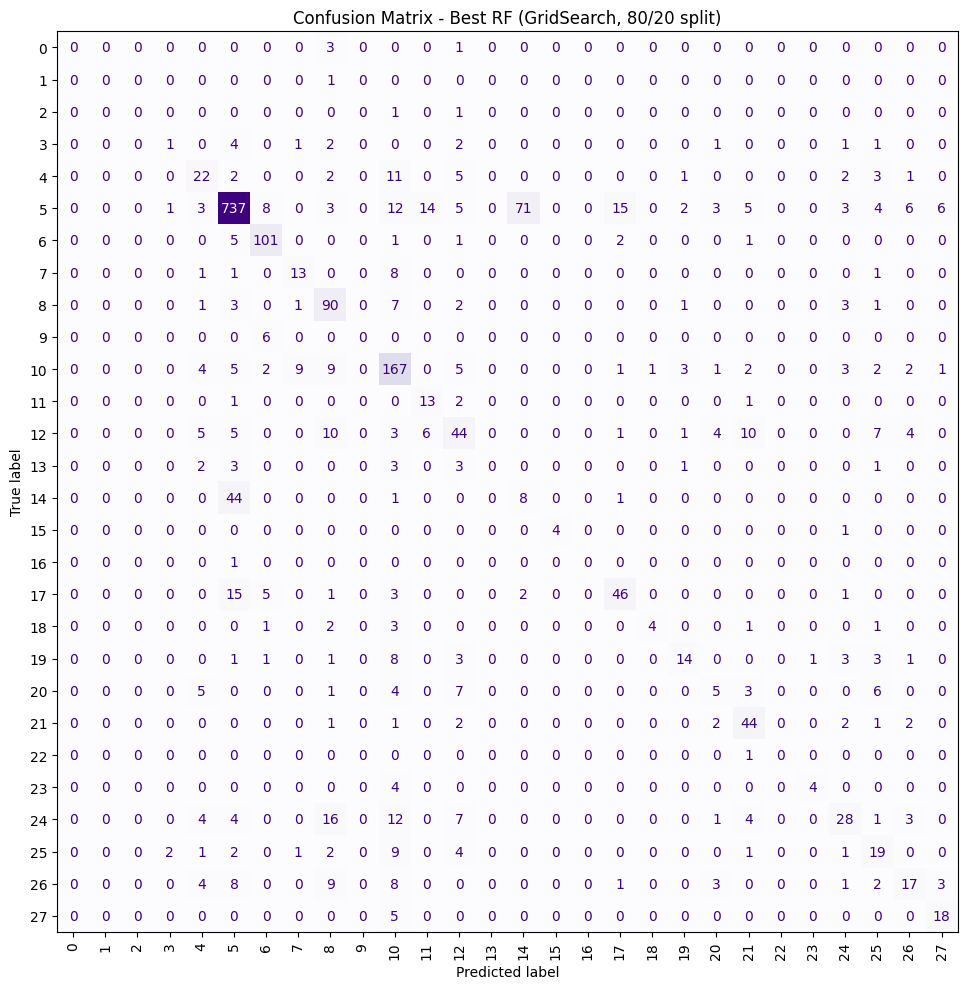

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Combine X_train_cleaned_rf + Test2[:202] as Training Set
X_train_combined_rf = np.vstack([X_train_cleaned_rf, X_test2_labeled_cleaned_rf])
y_train_combined_rf = np.hstack([y_train, y_test2])

# Train a Random Forest (RF) Model to Generate Pseudo-Label Probabilities for Test2[202:]
clf_rf_pseudo = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1, class_weight='balanced')
clf_rf_pseudo.fit(X_train_combined_rf, y_train_combined_rf)
y_test2_prob_rf = clf_rf_pseudo.predict_proba(X_test2_unlabeled_cleaned_rf)

# Filter Pseudo-Labeled Samples (High Confidence >= 0.90)
confidence_threshold = 0.90
max_probs = y_test2_prob_rf.max(axis=1)                   # Maximum predicted probability for each sample
pseudo_labels = y_test2_prob_rf.argmax(axis=1)            # Predicted labels

high_conf_idx = np.where(max_probs >= confidence_threshold)[0]  # Select high confidence indices
X_pseudo_rf = X_test2_unlabeled_cleaned_rf[high_conf_idx]       # Pseudo-labeled features
y_pseudo_rf = pseudo_labels[high_conf_idx]                       # Pseudo-labels

print(f"[GridSearch RF] Selected {len(high_conf_idx)} pseudo-labeled samples (confidence >= {confidence_threshold})")

# Extend Training Set (Original + Pseudo-Labeled Samples)
X_train_full_rf = np.vstack([X_train_combined_rf, X_pseudo_rf])
y_train_full_rf = np.hstack([y_train_combined_rf, y_pseudo_rf])

# Split Training Set into Training and Validation (80/20 Stratified Split)
X_train_split_rf, X_val_split_rf, y_train_split_rf, y_val_split_rf = train_test_split(
    X_train_full_rf, y_train_full_rf, test_size=0.2, stratify=y_train_full_rf, random_state=42
)

# Perform GridSearchCV to Tune Hyperparameters
param_grid = {
    'n_estimators': [200, 300, 400, 500],         # Number of trees
    'max_depth': [8, 12, 16, None],               # Maximum depth of trees
    'min_samples_split': [2, 5, 10],              # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4]                 # Minimum samples required at a leaf node
}
f1_macro = make_scorer(f1_score, average='macro')  # Macro F1 score as scoring metric
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold stratified CV

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, scoring=f1_macro, cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split_rf, y_train_split_rf)

print("\nBest Parameters:", grid_search.best_params_)      # Output best parameters
print("Best Macro F1 (CV):", grid_search.best_score_)      # Output best CV score

# Evaluate Best Model on Validation Set
best_rf = grid_search.best_estimator_
y_val_prob_best = best_rf.predict_proba(X_val_split_rf)    # Predicted probabilities
y_val_pred_best = best_rf.predict(X_val_split_rf)          # Predicted labels
y_val_onehot_best = label_binarize(y_val_split_rf, classes=np.arange(28))  # One-hot encoding of true labels

# Evaluation Metrics
print("\n[Best RF] Macro F1:", f1_score(y_val_split_rf, y_val_pred_best, average='macro'))
print("[Best RF] WCE Loss:", log_loss(y_val_onehot_best, y_val_prob_best))

print("\nClassification report:")
print(classification_report(y_val_split_rf, y_val_pred_best, digits=4))

# Confusion Matrix Visualization
cm_best = confusion_matrix(y_val_split_rf, y_val_pred_best, labels=np.arange(28))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=np.arange(28))
fig, ax = plt.subplots(figsize=(12, 10))
disp_best.plot(ax=ax, xticks_rotation='vertical', cmap='Purples', colorbar=False)
plt.title("Confusion Matrix - Best RF (GridSearch, 80/20 split)")
plt.tight_layout()
plt.show()


No pseudo-labels were selected (with a confidence level of 0.90);

The best parameter combination was found through the search;

On the validation set, the Macro F1 score is 0.398, and the Weighted Cross-Entropy (WCE) Loss is 1.41;

The confusion matrix shows that the recall of large classes is high, while the performance of small classes is unstable. 

**Objective**: Calculate the custom-defined Weighted Cross Entropy Loss on the validation set (consistent with that during training).

**Methods**:
1. Calculate the class weights as the reciprocal of the number of samples in each class, and then normalize these weights.
2. Use the class weights to compute the weighted log-loss for each individual sample. 

In [9]:
def weighted_log_loss(y_true, y_pred):
    class_counts = np.sum(y_true, axis=0)
    class_weights = 1.0 / class_counts
    class_weights /= np.sum(class_weights)

    sample_weights = np.sum(y_true * class_weights, axis=1)
    loss = -np.mean(sample_weights * np.sum(y_true * np.log(y_pred + 1e-12), axis=1))
    return loss

wce_loss_custom = weighted_log_loss(y_val_onehot_best, y_val_prob_best)
print("[Best RF] Weighted Cross Entropy Loss (Custom):", wce_loss_custom)


[Best RF] Weighted Cross Entropy Loss (Custom): 0.00984587658558357
